## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
#fundamental_df = pd.read_csv('tmp_factor.csv').iloc[:,1:]
universe_raw = pd.read_csv('AI_data/factors_AI_108.csv').iloc[:,1:]
universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y%m%d')
universe = universe_raw.set_index(['date']).sort_values(by=['date'])
universe = universe.fillna(method='ffill').fillna(0.)
print(universe.shape)

(69262, 9)


In [3]:
# only use from 2022.6 to 2023.4, here from 2022.5 in order to generate risk model from history
universe = universe.loc[universe['trade_date']>=20220401]
universe.columns

Index(['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
       'alpha_atr', 'alpha_010', 'alpha_AI'],
      dtype='object')

### Rescale AI factor

In [4]:
# need to fix excuteed in privious step
def rescale_AI(data):
    feature = 'alpha_AI'
    data[[feature]] = data[[feature]].apply(zscore)
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(), 
                                 np.where(data[feature]<0, data[feature]/-data[feature].min(), 0.))
    return data

universe = universe.groupby('trade_date').apply(rescale_AI)

0.015250568917702264


<AxesSubplot:>

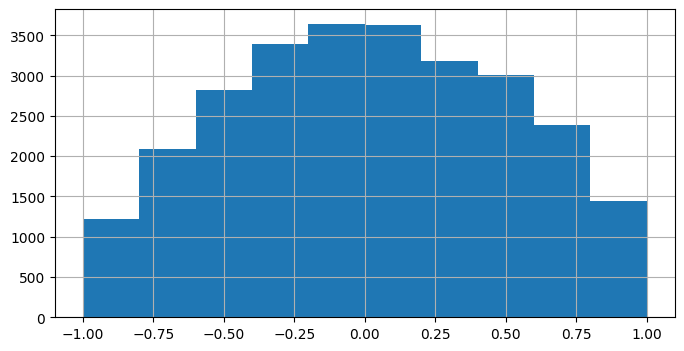

In [5]:
print(universe['alpha_AI'].mean())
universe['alpha_AI'].hist()

### Alignment Tickers
fill data to history by 0 in order to get align ticker marix data each day.

In [6]:
def init_holding(df):
    ticker_list = df.ts_code.unique()
    calendar = df.trade_date.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.trade_date == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                # date ts_code trade_date name industry close log-ret  alpha_atr, alpha_010, alpha_AI
                data = [pd.to_datetime(dt, format='%Y%m%d'), ticker, dt, check_df['name'],
                        check_df['industry'], 0., 0., 0., 0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date']) 
    return df

universe = init_holding(universe)

100%|█████████████████████████████████████████| 252/252 [00:02<00:00, 91.71it/s]


### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [7]:
## shif return 5 days
all_factors = universe.copy(deep=True)
all_factors = all_factors.sort_values(by=['date'])
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-2)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date'])
print(universe.shape, all_factors.shape)

(26964, 9) (26964, 10)


In [8]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']==20220601])

alpha_atr    0.008907
alpha_010    0.010479
alpha_AI     0.004788
dtype: float64

In [9]:
#all_factors.loc[all_factors['trade_date']>=20220601]

In [11]:
from scipy.stats import zscore
base_field = ['ts_code','trade_date','name', 'industry', 'close', 'log-ret']
alpha_field = ['alpha_atr', 'alpha_010', 'alpha_AI'] 
date_and_code = [ 'trade_date','ts_code', 'returns_2']

calendar = all_factors.trade_date.unique() # int64
alpha_df = all_factors[alpha_field + date_and_code]
facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df['trade_date']==dt])
facret[calendar[-1]]

regression factor returns: 100%|██████████████| 252/252 [00:04<00:00, 54.53it/s]


alpha_atr    0.0
alpha_010    0.0
alpha_AI     0.0
dtype: float64

#### Veiw Factor Returns

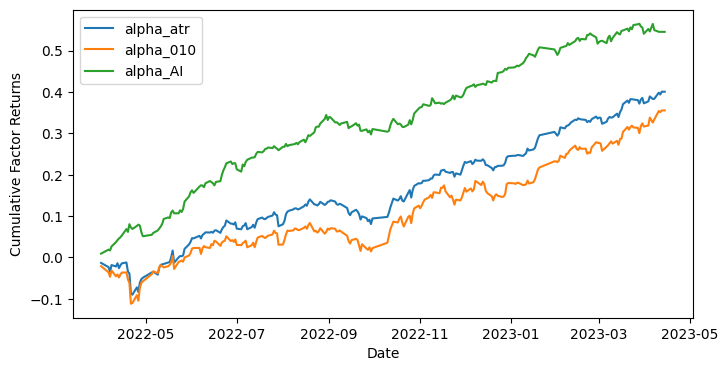

In [12]:
date_list = all_factors.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

### PCA model
We use PCA algorithm to estimate risk

In [13]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=252):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, 
                                            self.factor_returns_, self.factor_betas_, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [14]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 1
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    f = rm.factor_returns_
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, f, rm.idiosyncratic_var_vector

# test
start_time = 20220501
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 19
return date 20220505


ts_code,000411.SZ,000756.SZ,000915.SZ,002322.SZ,002362.SZ,002365.SZ,002380.SZ,002462.SZ,002577.SZ,002605.SZ,...,688230.SH,688244.SH,688259.SH,688314.SH,688317.SH,688358.SH,688579.SH,688589.SH,688655.SH,688799.SH
ts_code,,,,,,,,,,,,,,,,,,,,,
000411.SZ,0.388766,0.259558,0.280493,0.226155,0.207352,0.293972,0.167720,0.220568,0.239726,0.274778,...,0.332986,0.0,0.169777,0.213855,0.367046,0.221195,0.255134,0.317726,0.328504,0.201896
000756.SZ,0.259558,1.112718,0.235764,0.190091,0.174286,0.247093,0.140974,0.185395,0.201498,0.230960,...,0.279885,0.0,0.142703,0.179752,0.308514,0.185921,0.214448,0.267059,0.276118,0.169700
000915.SZ,0.280493,0.235764,0.472054,0.205423,0.188343,0.267023,0.152344,0.200348,0.217750,0.249589,...,0.302460,0.0,0.154214,0.194251,0.333398,0.200917,0.231745,0.288600,0.298389,0.183388
002322.SZ,0.226155,0.190091,0.205423,0.259873,0.151857,0.215294,0.122832,0.161536,0.175567,0.201237,...,0.243866,0.0,0.124339,0.156620,0.268811,0.161995,0.186850,0.232691,0.240584,0.147861
002362.SZ,0.207352,0.174286,0.188343,0.151857,0.181319,0.197393,0.112619,0.148105,0.160969,0.184506,...,0.223590,0.0,0.114001,0.143598,0.246461,0.148526,0.171315,0.213344,0.220581,0.135567


In [16]:
# check estimate risk at spicified time
h=np.array([1]*107) 
(np.dot(h, variance_i).dot(h.T))** 0.5

49.598651302525504

In [17]:
start_time = 20220501
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.mean(axis=0)]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 19
(24931, 3) (24931, 11)


### Combine Factors

In [18]:
#'alpha_atr_2', 'alpha_kama_5d', 'alpha_AI'
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code'])
alpha_df['alpha_all'] = 0.2 * alpha_df['alpha_atr'] + 0.01*alpha_df['alpha_010'] + 0.8*alpha_df['alpha_AI']
alpha_df = alpha_df.sort_values(by=['date'])                   
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

1.01 -1.01


### Backtest by Convex Optimization
- use `scipy.optimize.fmin_l_bfgs_b` top optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk rescale weights

In [23]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=5e-3, aversion=0.5): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + aversion * (np.dot(h, variance).dot(h.T)) / 252/19 \
             #+ Lambda * abs((h-h0)).sum()
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=5e-3, aversion=0.5):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) / 252/19 \
                #+ Lambda
        return f_hat
    return grad_func

# bounds means position bounds at each row. Here I only trade for long so that bounds from 0 to 1

#start_time = 20220601
alpha_df['h_privious'] = 0.
positions = {}
calendar = alpha_df.trade_date.unique()

# get parameter
ticker_num = len(alpha_df.index.get_level_values(1).unique())
h0 = [0.] * ticker_num
bounds = [(0,100)] * ticker_num

for dt in calendar:
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
    # convex optimize
    obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
    #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    
    # update optimize holding
    obj_df['h_opt'] = h_optimal
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal

6700.0 4540.1187732414855


<AxesSubplot:>

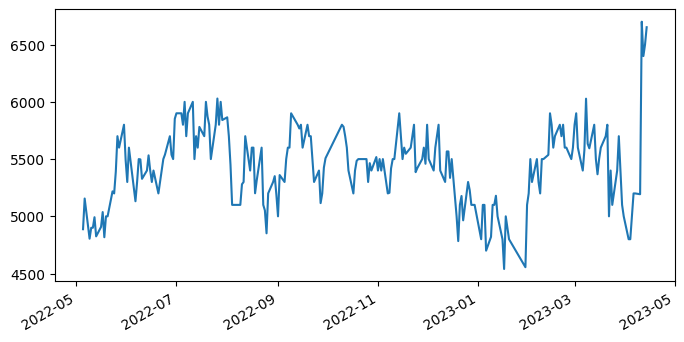

In [24]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
#positions[20230315]['h_opt'].hist()
calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=pd.to_datetime(calendar, format='%Y%m%d')).plot()

### Normalize optimal sum to 1

In [25]:
#for i in positions.keys():
#    positions[i]['h_opt'] = positions[i]['h_opt']/(positions[i]['h_opt'].sum())
#    positions[i]['h_privious'] = positions[i]['h_privious']/(positions[i]['h_privious'].sum())
    #positions[i]['h_opt'] = positions[i]['h_opt']/1500
    #positions[i]['h_privious'] = positions[i]['h_privious']/1500
h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

In [26]:
all_positions = []
for dt in list(positions.keys())[3:]:
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))

6700.0 4540.1187732414855


6500.0


trade_date  name industry  close   log-ret  alpha_atr  \
date       ts_code                                                            
2023-04-13 002462.SZ    20230413   嘉事堂     医药商业  14.88  0.010132   0.610115   
           002380.SZ    20230413  科远智慧     软件服务  18.95  0.019718   0.713468   
           002365.SZ    20230413  永安药业     化学制药  10.99  0.007306   0.998925   
           300231.SZ    20230413  银信科技     软件服务  10.49 -0.038340   0.828677   
           000756.SZ    20230413  新华制药     化学制药  24.15  0.002488   0.185001   
...                          ...   ...      ...    ...       ...        ...   
           688171.SH    20230413  纬德信息     软件服务  25.73  0.006629   0.418416   
           603508.SH    20230413  思维列控     软件服务  18.51  0.027939   0.791311   
           688317.SH    20230413  之江生物     医疗保健  31.85  0.009781   0.666042   
           688589.SH    20230413   力合微      半导体  48.94 -0.055636   0.202638   
           688655.SH    20230413   迅捷兴      元器件  14.82 -0.032529   0.746711   

                      alpha_010  alpha_AI  residual  alpha_all  h_privious  \
date       ts_code                                                           
2023-04-13 002462.SZ   0.266742       0.0  0.035997   0.124690       100.0   
           002380.SZ   0.783971       0.0  0.090239   0.150533       100.0   
           002365.SZ   0.993383       0.0  0.093166   0.209719       100.0   
           300231.SZ   1.000000       0.0  0.100808   0.175735       100.0   
           000756.SZ   0.293602       0.0  0.074444   0.039936         0.0   
...                         ...       ...       ...        ...         ...   
           688171.SH   0.514525       0.0  0.071310   0.088828         0.0   
           603508.SH   0.801302       0.0  0.062663   0.166275       100.0   
           688317.SH   0.252246       0.0  0.036011   0.135731       100.0   
           688589.SH   0.788718       0.0  0.238544   0.048415       100.0   
           688655.SH   0.887917       0.0  0.092627   0.158221       100.0   

                      h_opt  
date       ts_code           
2023-04-13 002462.SZ  100.0  
           002380.SZ  100.0  
           002365.SZ  100.0  
           300231.SZ  100.0  
           000756.SZ  100.0  
...                     ...  
           688171.SH  100.0  
           603508.SH  100.0  
           688317.SH  100.0  
           688589.SH  100.0  
           688655.SH  100.0  

[65 rows x 12 columns]

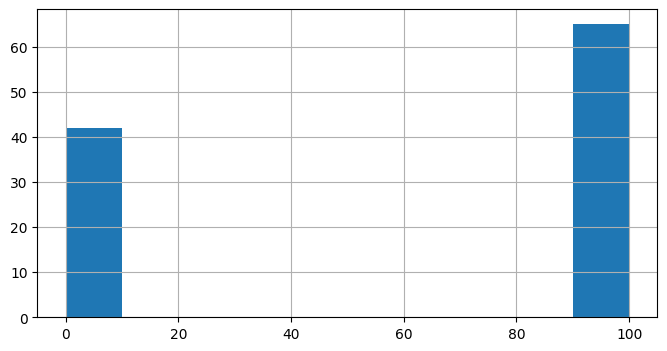

In [34]:
positions[20230413]['h_opt'].hist()
print(positions[20230413].loc[positions[20230413]['h_opt']>0]['h_opt'].sum())
positions[20230413].loc[positions[20230413]['h_opt']==100]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

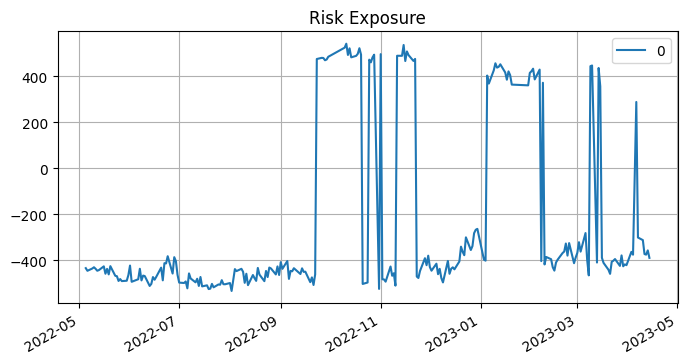

In [28]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### Alpha Exposure

<AxesSubplot:>

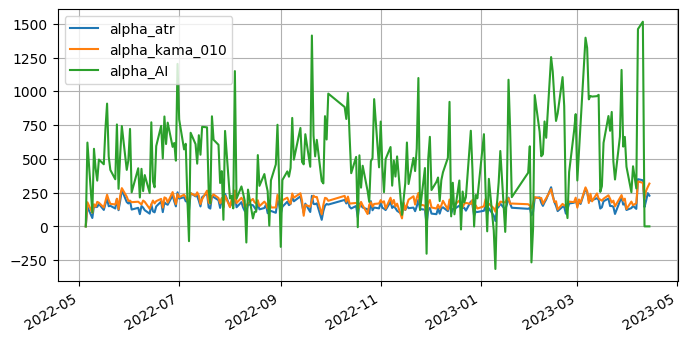

In [30]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code','alpha_atr', 'alpha_010', 'alpha_AI', 'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    # alpha_df['alpha_all'] = 0.7 * alpha_df['alpha_AI'] + 0.3*alpha_df['alpha_149'] + 0.1*alpha_df['alpha_010']
    B_alpha = B_alpha * [[0.1, 0.1, 0.8]] #* len(alpha_df_.ts_code.unique())
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=['alpha_atr', 'alpha_kama_010', 'alpha_AI'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
alpha_exposure_df.plot(grid=True)

471.975075899612


<AxesSubplot:>

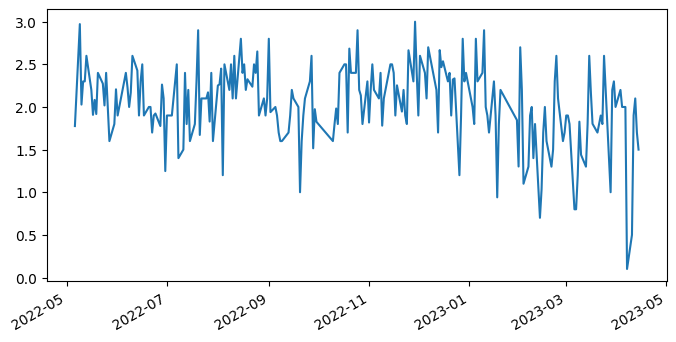

In [31]:
transaction_costs = []
Lambda = 1e-3
for i in range(1,len(h_optimal_list)):
    tmp_change = np.where((h_optimal_list[i] - h_privious_list[i])<0, h_privious_list[i] - h_optimal_list[i], 0)
    #costs = sum(np.dot(tmp_change.values**2, Lambda))
    costs = Lambda * tmp_change.sum()
    transaction_costs.append(costs)
print(sum(transaction_costs))
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d')).plot()

### Profit-and-Loss (PnL)

2023-04-10 00:00:00


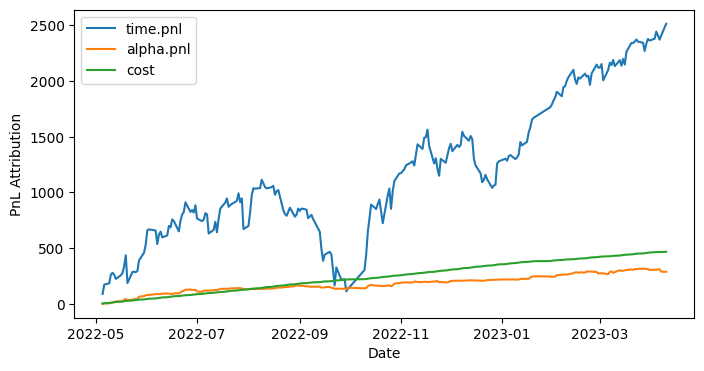

In [33]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d')).iloc[:-4,:]
    calendar = all_factors.trade_date.unique()[:-4]
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        #fr = facret[dt][[0,2,5]]
        fr = facret[dt].loc[['alpha_atr', 'alpha_010', 'alpha_AI']]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.2, 0.2)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        #df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        df.at[time_i,"cost"] = transaction_costs[ii]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()